In [1]:
import geopandas
import rioxarray
import pathlib
import matplotlib
import numpy
import shapely
import scipy.spatial
import xarray
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

Load in files - note using REC2.4 only because Ude used this when deriving population and slope over catchment patches. In future we should be using REC2.5

In [2]:
base_path = pathlib.Path(r"C:\Users\pearsonra\Documents\data\river_bathemetry")
rec2 = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\rec_domains\rec2_4\rec2_rivers.shp")
#dn3 = geopandas.read_file(r"")
domains = geopandas.read_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\rec_domains\rec2_4\super_domains_sort_traces.gpkg")
waikanae_lower_catchment = geopandas.read_file(
    r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\small_waikanae.shp")
westport_catchment = geopandas.read_file(
    r"C:\Users\pearsonra\Documents\data\Westport\catchments\Rough_Catchment_outline\Rough_Catchment_outline.zip")

Specify relevant fids

In [3]:
domain_waikanae_fid = 65 # minus one from that specified in QGIS
domain_westport_fid = 102 # minus one from that specified in QGIS
rec2_waikanae_id = 9253579
rec2_westport_id = 12035600

In [ ]:
#domains.iloc[domain_westport_fid]['geometry']

Cycle through the nodes from the initial ID using the NextDownID that matches the earch above and putting into a list. This can become a new GeoPandasDataframe of all polylines in a from coast to the upper catchment.

## A function to extract all polylines associated with a river

In [ ]:
rec2.columns

In [4]:
def get_down_stream_reaches(rec: geopandas.GeoDataFrame, reach_id: int, reaches: geopandas.GeoDataFrame, i: int):
    if i>8000:
        print(f"Reached recursion limit at: {i}")
        return reaches, i
    i += 1
    down_stream_reaches = rec[rec['NextDownID']==reach_id]
    reaches = reaches.append(down_stream_reaches)
    for index, down_stream_reach in down_stream_reaches.iterrows():
        if not down_stream_reach['Headwater']: 
            reaches, i = get_down_stream_reaches(rec=rec, reach_id=down_stream_reach['nzsegment'], reaches=reaches, i=i)
    
    return reaches, i

## Generate shape files for the Waikanae river

In [16]:
area_threshold = 125_000_000 # 10_000_000. 100_000_000

In [18]:
rec2[rec2['nzsegment']==rec2_waikanae_id]

,HydroID,NextDownID,CATAREA,CUM_AREA,nzsegment,Enabled,LENGTHDOWN,Headwater,Hydseq,StreamOrde,...,nzreach_re,headw_dist,segslpmax,segslpmean,LID,reachtype,FROM_NODE,TO_NODE,Shape_Leng,geometry
253495,253496,0,18001.0,152753696.0,9253579,1,0.0,0,256825,5,...,9003742,24527,0.0,0.0,0,0,259082,259083,15.0004,"LINESTRING (1769118.631 5473462.110, 1769103.6..."


<AxesSubplot:>

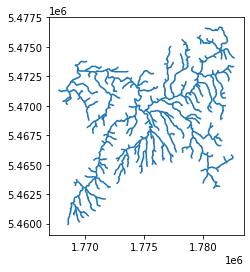

In [5]:
waikanae_river = rec2[rec2['nzsegment']==rec2_waikanae_id]
waikanae_river, i = get_down_stream_reaches(rec2, rec2_waikanae_id, waikanae_river, i=0)
waikanae_river.plot()

### Extract flat region

In [ ]:
flat_waikanae_river = waikanae_river.clip(domains.iloc[domain_waikanae_fid]['geometry'], keep_geom_type=True)
flat_waikanae_river_polygon = geopandas.GeoDataFrame(geometry=flat_waikanae_river.buffer(150))
flat_waikanae_river_polygon['label'] = 1
flat_waikanae_river_polygon = flat_waikanae_river_polygon.dissolve(by='label')
#flat_waikanae_river_polygon.plot()

### Extract flat region above area threshold
Extract teh flat reaches with more upstream area than the set threshold

<AxesSubplot:>

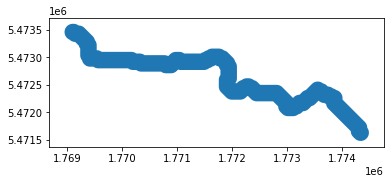

In [17]:
flat_waikanae_river_area = waikanae_river[waikanae_river['CUM_AREA']>area_threshold]
flat_waikanae_river_area_polygon = geopandas.GeoDataFrame(geometry=flat_waikanae_river_area.buffer(150))
flat_waikanae_river_area_polygon['label'] = 1
flat_waikanae_river_area_polygon = flat_waikanae_river_area_polygon.dissolve(by='label')
flat_waikanae_river_area_polygon.plot()

In [ ]:
flat_waikanae_river_area.plot()

### Save out Waikanae river shapefiles

In [ ]:
#waikanae_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_polyline.geojson")
#flat_waikanae_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_flat_polyline.geojson")
#flat_waikanae_river_polygon.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_flat_polygon.geojson")
flat_waikanae_river_area_polygon.to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_polygon_{area_threshold}.geojson")

## Generate shape files for the Westport river

In [ ]:
area_threshold = 10_000_000 # 10_000_000. 100_000_000
westport_river = rec2[rec2['nzsegment']==rec2_westport_id]
westport_river, i = get_down_stream_reaches(rec2, rec2_westport_id, westport_river, i=0)
#westport_river.plot()

In [ ]:
flat_westport_river = westport_river.clip(domains.iloc[domain_westport_fid]['geometry'], keep_geom_type=True)
#flat_westport_river.plot()

### Create flat polygon

In [ ]:
flat_westport_river_polygon = geopandas.GeoDataFrame(geometry=flat_westport_river.buffer(300))
flat_westport_river_polygon['label'] = 1
flat_westport_river_polygon = flat_westport_river_polygon.dissolve(by='label')
# flat_westport_river_polygon.plot()

### Extract flat region above area threshold
Extract the flat reaches with more upstream area than the set threshold

In [ ]:
flat_westport_river_area = flat_westport_river[flat_westport_river['CUM_AREA']>area_threshold]
flat_westport_river_area_polygon = geopandas.GeoDataFrame(geometry=flat_westport_river_area.buffer(300))
flat_westport_river_area_polygon['label'] = 1
flat_westport_river_area_polygon = flat_westport_river_area_polygon.dissolve(by='label')
#flat_westport_river_area_polygon.plot()

In [ ]:
flat_westport_river_area_polygon_in_catchment = flat_westport_river_area_polygon.clip(westport_catchment, keep_geom_type=True)
flat_westport_river_area_polygon_in_catchment.plot()

### Save out Westport river files

In [ ]:
#westport_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\westport_polyline.geojson")
#flat_westport_river.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\westport_flat_polyline.geojson")
#flat_westport_river_polygon.to_file(r"C:\Users\pearsonra\Documents\data\river_bathemetry\westport\westport_flat_polygon.geojson")
flat_westport_river_area_polygon_in_catchment.to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\westport\westport_polygon_{area_threshold}.geojson")

# Separate out River - edge detection - after manual placement of river in QGIS based of DEM & satallite
At polyline nodes - calculate perpindicular transect - look at slope change along this - cell to cell & slope change
* calculate width
* calculate avg elevation of 'river' bit

In [ ]:
transect_length = 100 # in both directions
resolution = 1
sampling_resolution = 10 # transect spacing up river

## Waikanae

In [ ]:
waikanae_manual_rivers = geopandas.read_file(base_path / "waikanae\manual_river_centre_100000000\manual_river_centre_100000000.geojson")
with rioxarray.rioxarray.open_rasterio(base_path / r"waikanae\clipped\results\1m_100000000_gnd.nc", masked=True) as waikane_dem:
            waikane_dem.load()
with rioxarray.rioxarray.open_rasterio(base_path / r"waikanae\clipped\results\1m_100000000_gnd_linear.nc", masked=True) as waikane_dem_linear:
            waikane_dem_linear.load()

### Get perpindicular sample lines from manual rivers
### Subsample every ten metres

In [ ]:
def subsample_channels(channel_centre_lines: geopandas.GeoDataFrame, channel_id: int, sampling_resolution: float):
    line_string = channel_centre_lines.loc[channel_id]['geometry']
    sampled_channel_centre_lines = geopandas.GeoDataFrame({'id': [channel_id], 'geometry': shapely.geometry.LineString(
        [channel_centre_lines.loc[channel_id]['geometry'].interpolate(i * sampling_resolution) for i in range(int(numpy.ceil(channel_centre_lines.loc[channel_id]['geometry'].length/sampling_resolution)))])},
                                                          crs = channel_centre_lines.crs)
    return sampled_channel_centre_lines

In [ ]:
sampled_waikanae_manual_rivers=subsample_channels(waikanae_manual_rivers, 0, sampling_resolution)

In [ ]:
waikanae_manual_rivers.length

### Sample elevations along main channel

In [ ]:
def transects_along_reaches(channel_centre_lines: geopandas.GeoDataFrame, channel_id: int, transect_length: float):
    transects = {'geometry':[], 'nx':[], 'ny':[], 'midpoint': [], 'length': []}
    (x_array, y_array) = channel_centre_lines.loc[channel_id].geometry.xy
    for i in range(len(x_array)-1):
        # calculate midpoint
        midpoint = [(x_array[i] + x_array[i+1])/2, (y_array[i] + y_array[i+1])/2]

        # caclulate slope along segment
        dx = (x_array[i+1] - x_array[i])/numpy.sqrt((x_array[i+1] - x_array[i])**2 + (y_array[i+1] - y_array[i])**2)
        dy = (y_array[i+1] - y_array[i])/numpy.sqrt((x_array[i+1] - x_array[i])**2 + (y_array[i+1] - y_array[i])**2)
        
        # record nirmal to a segment nx and ny
        transects['nx'].append(-dy)
        transects['ny'].append(dx)

        # calculate transect - using effectively nx and ny
        transects['geometry'].append(shapely.geometry.LineString([[midpoint[0] + transect_length * dy, midpoint[1] - transect_length * dx],
                                                      midpoint,
                                                      [midpoint[0] - transect_length * dy, midpoint[1] + transect_length * dx]]))
        transects['midpoint'].append(shapely.geometry.Point(midpoint))
        # record the length of the line segment
        transects['length'].append(numpy.sqrt((x_array[i+1]-x_array[i])**2 + (y_array[i+1] - y_array[i])**2))
    transects = geopandas.GeoDataFrame(transects, crs=channel_centre_lines.crs) 
    return transects

In [ ]:
transects = transects_along_reaches(sampled_waikanae_manual_rivers, 0, transect_length)

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(11, 4))

waikane_dem.plot(ax=ax)

waikanae_manual_rivers[waikanae_manual_rivers['id']==0].plot(color='green', linewidth=3, ax=ax)

transects.plot(color='blue',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
matplotlib.pyplot.show()

### Sample elevations along each transect at the resolution

In [ ]:
def sample_from_transects(transects: geopandas.GeoDataFrame, dem: xarray.core.dataarray.DataArray, transect_length: float, resolution: float):
    
    # number of transect samples - ensure be odd
    number_of_samples = int(numpy.floor(transect_length/resolution) * 2 - 1)
    sample_index_array = numpy.arange(-numpy.floor(number_of_samples/2), numpy.floor(number_of_samples/2) + 1, 1)
    
    transect_samples = {'elevations': [], 'xx': [], 'yy': [], 'min_z':[]}
    
    # create tree to sample from
    grid_x, grid_y = numpy.meshgrid(dem.x, dem.y)
    xy_in = numpy.concatenate([[grid_x.flatten()], [grid_y.flatten()]], axis=0).transpose()
    tree = scipy.spatial.KDTree(xy_in)
    
    # cycle through each transect - calculate sample points then look up
    for index, row in transects.iterrows():
        #calculate xx, and yy points to sample at
        if row['nx'] == 0:
            xx=row.midpoint.x + numpy.zeros(number_of_samples)
        else:
            xx=row.midpoint.x + sample_index_array * resolution * row['nx']
        if row['ny'] == 0:
            yy=row.midpoint.y + numpy.zeros(number_of_samples)
        else:
            yy=row.midpoint.y + sample_index_array * resolution * row['ny']
        
        # Sample the elevations at along the transect
        xy_points = numpy.concatenate([[xx], [yy]], axis=0).transpose()
        assert len(xy_points) == 199, f"{len(xx)}, {len(yy)}, {len(xy_points)}, {row['nx']}, {row['ny']}"
        distances, indices = tree.query(xy_points)
        elevations = dem.data.flatten()[indices]
        transect_samples['elevations'].append(elevations)
        transect_samples['min_z'].append(numpy.nanmin(elevations))
    
    return transect_samples

In [ ]:
numpy.argmin([1,2,3, numpy.nan])

In [ ]:
transect_samples = sample_from_transects(transects, waikane_dem, transect_length, resolution)
transect_samples_linear = sample_from_transects(transects, waikane_dem_linear, transect_length, resolution)

### Plot transect elevations

In [ ]:
for elevations, min_z in zip(transect_samples['elevations'], transect_samples['min_z']):
    matplotlib.pyplot.plot(elevations - min_z)

In [ ]:
for elevations, min_z in zip(transect_samples_linear['elevations'], transect_samples_linear['min_z']):
    matplotlib.pyplot.plot(elevations - min_z)

# Calculate width and slope
Use the linear interpolation as we have results everywhere

In [ ]:
def width_from_samples(transects: geopandas.GeoDataFrame, transect_samples: dict, threshold: float, resolution: float):
    
    widths = {'widths': [], 'first_widths': [], 'last_widths': []}
    
    for j in range(len(transect_samples['elevations'])):
    
        assert numpy.floor(len(transect_samples['elevations'][j])/2) != len(transect_samples['elevations'][j])/2, "Expect an odd length"
        start_i = numpy.nan
        stop_i = numpy.nan
        centre_index = int(numpy.floor(len(transect_samples['elevations'][j])/2))
        
        for i in numpy.arange(0, centre_index, 1):
            # work forward checking height
            if transect_samples['elevations'][j][centre_index + i] - transects.loc[j]['upstream_min_z'] > threshold and numpy.isnan(stop_i):
                stop_i = centre_index + i
            # work backward checking height
            if transect_samples['elevations'][j][centre_index - i] - transects.loc[j]['upstream_min_z'] > threshold and numpy.isnan(start_i):
                start_i = centre_index - i
        
        widths['first_widths'].append((centre_index-start_i)*resolution)
        widths['last_widths'].append((stop_i-centre_index)*resolution)
        widths['widths'].append((stop_i - start_i)*resolution)
    
    return widths

In [ ]:
def width_from_samples_zeroed(transects: geopandas.GeoDataFrame, transect_samples: dict, threshold: float, resolution: float):
    
    widths = {'widths': [], 'first_widths': [], 'last_widths': []}
    
    for j in range(len(transect_samples['elevations'])):
        
        zeroed_elevations = transect_samples['elevations'][j]-transects.loc[j]['mean_min_z']
    
        assert numpy.floor(len(zeroed_elevations)/2) != len(zeroed_elevations)/2, "Expect an odd length"
        start_i = numpy.nan
        stop_i = numpy.nan
        centre_index = int(numpy.floor(len(zeroed_elevations)/2))
        
        for i in numpy.arange(0, centre_index, 1):
            # work forward checking height
            if zeroed_elevations[centre_index + i] - zeroed_elevations[centre_index] > threshold and numpy.isnan(stop_i):
                stop_i = centre_index + i
            # work backward checking height
            if zeroed_elevations[centre_index - i] - zeroed_elevations[centre_index] > threshold and numpy.isnan(start_i):
                start_i = centre_index - i
        
        widths['first_widths'].append((centre_index-start_i)*resolution)
        widths['last_widths'].append((stop_i-centre_index)*resolution)
        widths['widths'].append((stop_i - start_i)*resolution)
    
    return widths

Calculate the rolling average of minimum elevations - note same for samples and linear interpolated samples

In [ ]:
transects['min_z'] = transect_samples['min_z']
transects['mean_min_z'] = transects['min_z'].rolling(5, center=True).mean()
transects.loc[numpy.isnan(transects['mean_min_z']), ('mean_min_z')] = transects['min_z'][numpy.isnan(transects['mean_min_z'])]

Calculate the minimum upstream river depth

In [ ]:
min_z = transects['mean_min_z']
upstream_min_z = numpy.zeros(len(min_z))
upstream_min_z[-1] = min_z[len(min_z) - 1]
for i in range(len(min_z) - 2, -1, -1): # range [len-1, len-2, len-3, ..., 2, 1, 0]
    upstream_min_z[i] = min_z[i] if min_z[i] < upstream_min_z[i + 1] else upstream_min_z[i + 1]
transects['upstream_min_z'] = upstream_min_z

## Calculate widths

In [ ]:
threshold = 1
widths_linear = width_from_samples(transects, transect_samples_linear, threshold, resolution)
widths = width_from_samples(transects, transect_samples, threshold, resolution)

In [ ]:
widths_input = widths

In [ ]:
def apply_bank_width(midpoint, nx, ny, first_widths, last_widths):
    
    return shapely.geometry.LineString([[midpoint.x - first_widths * nx, midpoint.y - first_widths * ny],
                                                      midpoint,
                                                      [midpoint.x + last_widths * nx, midpoint.y + last_widths * ny]])

In [ ]:
transects['width'] = widths_input['widths']
transects['first_widths'] = widths_input['first_widths']
transects['last_widths'] = widths_input['last_widths']
transects['slope'] = transects['upstream_min_z'].diff()/transects['length']
transects['width_line'] = transects.apply(lambda x: apply_bank_width(x['midpoint'], x['nx'], x['ny'], x['first_widths'], x['last_widths']), axis=1)

In [ ]:
transects.loc[transects['width']==0, ('width')] = numpy.nan

In [ ]:
display_line_widths = geopandas.GeoDataFrame(geometry=transects['width_line'][~numpy.isnan(transects['width'])], crs=transects.crs)

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))

waikane_dem.plot(ax=ax)

waikanae_manual_rivers[waikanae_manual_rivers['id']==0].plot(color='green', linewidth=3, ax=ax)

display_line_widths.plot(color='blue',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
matplotlib.pyplot.show()

### Save out results
* Table: 10m spaced width, height and slope values along the reach - alongside the midpoint values
* Plot: width as a line over the LiDAR - will need the midpoint, nx, ny, and start and stop indices

In [ ]:
transects.drop(columns=['midpoint', 'width_line']).to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_trasects_mean_depth_{sampling_resolution}m_downriver_{threshold}m_bank_thresh_upstream_linear.geojson")
display_line_widths.to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_width_mean_depth_{sampling_resolution}m_downriver_{threshold}m_bank_thresh_upstream_linear.geojson")

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))
transects['width'].plot(ax=ax)
ax.set(title=f"Widths for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width in m");

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))
transects['width'].plot(ax=ax)
ax.set(title=f"Widths for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width in m");

In [ ]:
f, ax = matplotlib.pyplot.subplots(figsize=(20, 8))
transects['width'].plot(ax=ax)
ax.set(title=f"Widths for {threshold}m threshold")
matplotlib.pyplot.xlabel(f"Transect number (spaced every {sampling_resolution}m upstream)")
matplotlib.pyplot.ylabel(f"River width in m");

## Plot width on line plot with elevation transect

## Plot bank locations alongside transects on DEM in plan view

## Save out river bank points or width lines

In [ ]:
flat_waikanae_river_area.head(5)

# Find which reach id a section intersects with

In [ ]:
transects_to_matt = transects.drop(columns=['nx', 'ny', 'length', 'min_z', 'first_widths', 'last_widths', 'width_line', 'mean_min_z', 'upstream_min_z'])
transects_to_matt['nzsegment'] = numpy.zeros(len(transects_to_matt['width']), dtype=int) * -1
for i, row in flat_waikanae_river_area.iterrows():
    transects_to_matt.loc[transects_to_matt.intersects(row.geometry), ('nzsegment')] = row['nzsegment']

In [ ]:
transects_to_matt.to_csv(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_river_widths_at_{sampling_resolution}m_upriver_spacing_{threshold}m_bank_threshold_upstream.csv")

In [ ]:
transects_to_matt.drop(columns=['midpoint']).to_file(fr"C:\Users\pearsonra\Documents\data\river_bathemetry\waikanae\waikanae_river_widths_at_{sampling_resolution}m_upriver_spacing_{threshold}m_bank_threshold_upstream.geojson")

In [ ]:
transects_to_matt

In [ ]:
transects_to_matt.loc[transects_to_matt.intersects(flat_waikanae_river_area.iloc[].geometry), ('nzsegment')] = row['nzsegment']

In [ ]:
flat_waikanae_river_area.head()